In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, davies_bouldin_score, completeness_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

In [32]:
# Step 1: Load the processed data
file_path = '../data/final_team_cluster_data2 copy.csv'
final_team_cluster_data = pd.read_csv(file_path)

In [33]:
# Add league information from the matches dataset
matches_file_path = '../data/ginf.csv'
matches_data = pd.read_csv(matches_file_path)
team_league_map = pd.concat([matches_data[['ht', 'league']], matches_data[['at', 'league']].rename(columns={'at': 'ht'})])
team_league_map = team_league_map.drop_duplicates().set_index('ht')['league'].to_dict()
final_team_cluster_data['league'] = final_team_cluster_data['event_team'].map(team_league_map)


In [34]:
# Prepare data for clustering
team_names = final_team_cluster_data['event_team']
league_labels = final_team_cluster_data['league']  # Actual league labels
clustering_features = final_team_cluster_data.drop(columns=['event_team', 'league'])

In [35]:
# Step 2: Apply K-Means Clustering
n_clusters = 5
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_model.fit(clustering_features)
final_team_cluster_data['cluster'] = kmeans_model.labels_

In [36]:
# Step 3: Evaluate Clustering
silhouette = silhouette_score(clustering_features, kmeans_model.labels_)
ari = adjusted_rand_score(league_labels, kmeans_model.labels_)
homogeneity = homogeneity_score(league_labels, kmeans_model.labels_)
completeness = completeness_score(league_labels, kmeans_model.labels_)
dbi = davies_bouldin_score(clustering_features, kmeans_model.labels_)

# Print Metrics
print(f"Silhouette Score: {silhouette:.2f}")
print(f"Adjusted Rand Index (ARI): {ari:.2f}")
print(f"Homogeneity Score: {homogeneity:.2f}")
print(f"Completeness Score: {completeness:.2f}")
print(f"Davies-Bouldin Index: {dbi:.2f}")

Silhouette Score: 0.17
Adjusted Rand Index (ARI): 0.16
Homogeneity Score: 0.31
Completeness Score: 0.37
Davies-Bouldin Index: 1.65


In [37]:
# Step 4: Assign a League to Each Cluster
cluster_league_df = final_team_cluster_data[['cluster', 'league']]
cluster_to_league = (
    cluster_league_df.groupby('cluster')['league']
    .agg(lambda x: x.value_counts().index[0])  # Most frequent league
    .to_dict()
)
print("\nMost Common League for Each Cluster:")
for cluster, league in cluster_to_league.items():
    print(f"Cluster {cluster}: {league}")


Most Common League for Each Cluster:
Cluster 0: E0
Cluster 1: F1
Cluster 2: I1
Cluster 3: E0
Cluster 4: I1


In [38]:
final_team_cluster_data['predicted_league'] = final_team_cluster_data['cluster'].map(cluster_to_league)


In [39]:
# Compute Accuracy
correct_predictions = final_team_cluster_data['predicted_league'] == final_team_cluster_data['league']
accuracy = correct_predictions.mean()
print(f"\nClustering Accuracy: {accuracy:.2f}")


Clustering Accuracy: 0.47


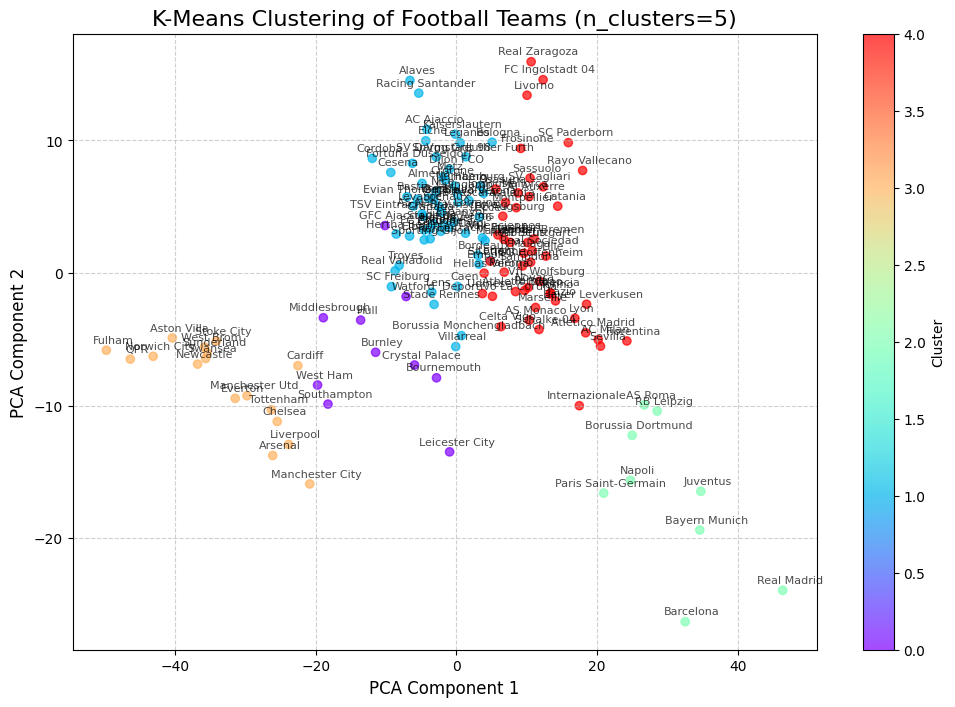

In [40]:
# Step 5: Visualize Clusters with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(clustering_features)
final_team_cluster_data['pca_x'] = pca_features[:, 0]
final_team_cluster_data['pca_y'] = pca_features[:, 1]

# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    final_team_cluster_data['pca_x'], 
    final_team_cluster_data['pca_y'], 
    c=final_team_cluster_data['cluster'], 
    cmap='rainbow', 
    alpha=0.7
)
plt.colorbar(scatter, label='Cluster')
plt.title(f'K-Means Clustering of Football Teams (n_clusters={n_clusters})', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)

# Annotate team names
for i, team in enumerate(team_names):
    plt.annotate(
        team,
        (final_team_cluster_data['pca_x'][i], final_team_cluster_data['pca_y'][i]),
        fontsize=8,
        alpha=0.7,
        textcoords="offset points",
        xytext=(5, 5),
        ha='center'
    )
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()